In [124]:

import sklearn
import itertools
import tensorflow as tf
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib
import time
import sys
import pymongo

sys.path.append('../source/')
sys.path.append('../scripts/')

import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from functools import reduce
import seaborn as sns
sns.set()
results_path = "../images/model results/"
def saveFig():
    plt.savefig(results_path+model_name+" "+input(),dpi=300,bbox_inches='tight')

In [125]:
class PredictionModel:
    def __init__(self,data, input_lag, output_lag, sequence_length,scale_max=False,scale_log=False,shift_mean=False,y_only=False,add_time=False,max_value=130,valid_split=0.8,min_max_scale=False,differentiate_y=False):
        self.data = data
        self.input_lag = input_lag
        self.output_lag = output_lag
        self.sequence_length = sequence_length
        self.scale_max = scale_max
        self.scale_log = scale_log
        self.shift_mean = shift_mean
        self.y_only=y_only
        self.add_time = add_time
        self.max_value = max_value
        self.min_max_scale = min_max_scale
        self.differentiate_y=differentiate_y
        self.model=None
        self.valid_split=valid_split
        self.x,self.y,self.t =self.getXY()
        self.__reversed_process=[]
    
    
    
    def getDaysTypes(self):
        day_types = pd.DatetimeIndex(self.t.reshape(-1)).weekday.values.reshape(self.t.shape)
        time_fraction = (CustomUtils.timeToSeconds(pd.DatetimeIndex(data_model.t.reshape(-1)))/(60*60)).values.reshape(self.t.shape)
        time_input = np.concatenate([day_types,time_fraction],1)
        return time_input[:int(len(self.x)*(self.valid_split))],time_input[int(len(self.x)*(self.valid_split)):]
    
    def getExamples(self,sequence,hours):
        sequence_length=len(sequence)
        sub_sequence_length = self.input_lag+self.output_lag
        if sub_sequence_length > sequence_length :
            raise ValueError("sequence length {} too small for lags : {},{}".format(sequence_length,input_lag,output_lag))
        return [sequence[i:i+input_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)],\
               [sequence[i+input_lag:i+input_lag+output_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)],\
               [hours[i+input_lag:i+input_lag+output_lag] for i in range(0,sequence_length-sub_sequence_length+1,1)]  
    
    def getXY(self):
        nsegs,ntime=self.data.shape
        if(ntime%self.sequence_length)!= 0 :
            raise ValueError("sequence length {} not compatible with number of time features {}".format(self.sequence_length,ntime))

        shapedData = self.data.values.T.reshape(int(ntime/self.sequence_length),self.sequence_length,nsegs)
        timestamps = pd.Series(self.data.columns).values.reshape(int(ntime/self.sequence_length),self.sequence_length)
        
        examples=[self.getExamples(x,hours) for x,hours in zip(shapedData,timestamps)]

        x,y,t = list(zip(*examples))
        return np.concatenate(x), np.concatenate(y), np.concatenate(t)
    
    
    def getIndexes(self,idx):
        cx,cy= (idx +(self.input_lag+self.output_lag-1)*(idx//(self.sequence_length - self.input_lag-self.output_lag+1)),\
                idx +(self.input_lag+self.output_lag-1)*(idx//(self.sequence_length - self.input_lag-self.output_lag+1))+self.input_lag )
        return (self.data.columns[cx:cy].values,self.data.columns[cy:cy+self.output_lag].values)
    
    def scaleMax(self):
        self.__reversed_process.append(self.reverseScaleMax)
        self.x/=self.max_value
        if not self.y_only:
            self.y/=self.max_value
        
    def scaleMinMax(self):
        self.__reversed_process.append(self.reverseMinMaxScale)
        self.min =self.x[:int(len(self.x)*(self.valid_split))].min()
        self.max =self.x[:int(len(self.x)*(self.valid_split))].max()
        diff = self.max - self.min
        self.x = (self.x-self.min)/diff
        self.y = (self.y-self.min)/diff

        
    def reverseMinMaxScale(self,x):
        return x*(self.max-self.min)+self.min
    
    def reverseScaleMax(self,y):
        return y*self.max_value

        
    def scaleLog(self):
        self.__reversed_process.append(self.reverseScaleLog)
        
        self.x=np.log1p(self.x)
        self.y=np.log1p(self.y)
        
    def reverseScaleLog(self,y):
        return np.expm1(y)       
        
    def addTime(self):
        self.__reversed_process.append(self.removeTime)
        self.x=np.concatenate((self.x,self.t.reshape(-1,self.t.shape[1],1)),2)
        
        
    def removeTime(self,y):
        if y.shape == self.x.shape :
            return np.delete(data_model.x,data_model.x.shape[2]-1,axis=2)
        return y
        
    def shiftMean(self):
        self.__reversed_process.append(self.resetMean)
        self.means  =  self.data[self.data.columns[:(int(len(self.data.columns)*self.valid_split))]].mean(axis=1).values
        if not self.y_only :
            self.x-=self.means
        self.y-=self.means
        
    def resetMean(self,y):
        return y+self.means
        
        
    def preprocessData(self):


        if self.differentiate_y :
            self.differentiateY()

        if self.shift_mean :
            self.shiftMean()
            
        if self.scale_max :
            self.scaleMax()
            
        if self.scale_log :
            self.scaleLog()
        if self.min_max_scale : 
            self.scaleMinMax()
        if self.add_time :
            self.addTime()
        if self.output_lag == 1 :
            self.y=self.y.reshape(-1,self.y.shape[2])

    def getRawYData(self,y):
        
        return reduce(lambda res, f:f(res), self.__reversed_process[::-1], y)

    
    def differentiateY(self):
        self.__reversed_process.append(self.reverseDifferentiatedY)
        self.y = self.y-self.x[:,-1:,:]
    
    def reverseDifferentiatedY(self,y):
        if len(y.shape)>2  : return y
        if self.output_lag >1 :
            return y+self.x[:,-1:,:]
        return y+self.x[:,-1,:]
    def mse(self,p,y=None):

        
        pred = self.getRawYData(p)
        if y is not None :
            raw_y = self.getRawYData(y)
        else :
            raw_y = self.getRawYData(self.y)
        return np.mean((pred-raw_y)**2)
    
    def mae(self,p,y=None):

        pred = self.getRawYData(p)
        if y is not None :
            raw_y = self.getRawYData(y)
        else :
            raw_y = self.getRawYData(self.y)
        return np.mean(abs(pred-raw_y))
    
    def trainSplit(self):
        
        x_train = self.x[:int(len(self.x)*(self.valid_split))]
        x_test = self.x[int(len(self.x)*(self.valid_split)):]
        y_train = self.y[:int(len(self.x)*(self.valid_split))]
        y_test = self.y[int(len(self.x)*(self.valid_split)):]
        return x_train,y_train,x_test,y_test
    
    def getSplitSequences(self,values,sequence_length,skip=0):
        def addNans(values,sequence_length,skip):

            values=values.reshape(-1,sequence_length)
            nans=np.array([np.nan]*(values.shape[0]*(skip+1))).reshape(values.shape[0],-1)
            values = np.concatenate((values,nans),axis=1).reshape(-1)
            return values
        return addNans(np.arange(len(values)),sequence_length,skip), addNans(values,sequence_length,skip)
    
    def restorePredictionsAsDF(self,preds):
        
        index = [self.getIndexes(i)[1][0] for i in range(len(preds))]
        df = pd.DataFrame(self.getRawYData(preds),index=index,columns=self.data.index)
        return df.T
    
    def restoreXAsDF(self,x):
        index = [self.getIndexes(i)[1][0] for i in range(len(x))]
        df = pd.DataFrame(self.getRawYData(x).swapaxes(1,2).tolist(),index=index,columns=self.data.index)
        return df.T
    
    def predict(self,split="full"):
        secondary_input = self.getDaysTypes()
        if split.lower() == "full":
            main_input = self.x
            secondary_input = np.concatenate(secondary_input)
        if split.lower() == "train":
            main_input,*_ = self.trainSplit()
            secondary_input=secondary_input[0]
        if split.lower() == "test":
            *_,main_input,_ = self.trainSplit()
            secondary_input=secondary_input[1]
            
        if(len(self.model.input_shape)==1):
            if len(self.model.outputs)>1 :
                return self.model.predict(main_input)[0]
        
            return self.model.predict(main_input)
        if len(self.model.outputs)>1 :
            return self.model.predict([main_input,secondary_input])[0]
        return self.model.predict([main_input,secondary_input])

In [126]:
def fillNaWithHistoricalValues(df):
    oldIdx = df.columns
    idx=[pd.to_datetime(df.columns.values).date,pd.to_datetime(df.columns.values).time]
    mIdx=pd.MultiIndex.from_arrays(idx,names=['day','time'])
    df.set_axis(mIdx,axis=1,inplace=True)
    df = df.add(df.isna()*df.groupby(by=df.columns.get_level_values(1),axis=1).mean(),fill_value=0)
    df.set_axis(oldIdx,axis=1,inplace=True)
    return df
def dropWeekends(data):
    data.drop(data.columns[[ x.date().weekday()>=5 for x  in data.columns]],axis=1,inplace=True)
#     data.drop(data.columns[[ x.date()==data.columns[0].date() for x  in data.columns]],axis=1,inplace=True)


In [127]:
speeds = pd.read_pickle("../data/monthsSpeed.pckl")
counts = pd.read_pickle('../data/monthsCount.pckl')

In [128]:
dropWeekends(speeds)
dropWeekends(counts)

In [129]:
days_count =counts.groupby(pd.DatetimeIndex(speeds.columns).date,axis=1).sum().sum()
days_quarter_count = pd.Series(speeds.columns.date).value_counts()
days_index=np.intersect1d(days_count[days_count>100000].index,days_quarter_count[days_quarter_count==20].index)

In [130]:
speeds=speeds[speeds.columns[[ x.date() in days_index for x  in speeds.columns]]]
counts = counts[speeds.columns[[ x.date() in days_index for x  in speeds.columns]]]

In [131]:
mergeResults,segmentsMeta, mergedSegments= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=osmMerger.WEIGHTS,speedsMx=speeds)
mergeResults.to_pickle("../data/mergeResults.pckl")
segmentsMeta.to_pickle("../data/segmentsMeta.pckl")

Computing raw data : 
first time call or reset : starting counter
getting segments and meta :
time spent 51.6 s
getting speed matrix :
time spent 0.1 s
computing meta attributs and inversed index :
time spent 0.2 s
computing merging criteria :
time spent 137.8 s
start merging :
iter :  1  seg 1 :  5970  seg2 :  5943  inv seg2 :  5943  mean non null  0.27021731744453814
iter :  101  seg 1 :  5360  seg2 :  5357  inv seg2 :  5357  mean non null  0.2722443890274315
iter :  201  seg 1 :  5995  seg2 :  5994  inv seg2 :  5994  mean non null  0.27547902984589373
iter :  301  seg 1 :  4221  seg2 :  4218  inv seg2 :  4218  mean non null  0.27928831271909516
iter :  401  seg 1 :  1547  seg2 :  1555  inv seg2 :  1555  mean non null  0.2832509717944235
iter :  501  seg 1 :  3580  seg2 :  3577  inv seg2 :  3577  mean non null  0.2875535423480629
iter :  601  seg 1 :  2349  seg2 :  2351  inv seg2 :  2351  mean non null  0.2922211851893127
iter :  701  seg 1 :  2271  seg2 :  2286  inv seg2 :  2286  me

In [9]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

In [10]:
def getAccessMx(segmentsMeta):
    acc=pd.DataFrame([np.arange(segmentsMeta.index.max()+1),np.arange(segmentsMeta.index.max()+1)]).T
    acc.columns=["idx1","idx2"]
    acc=acc.set_index(["idx1","idx2"]).assign(vals=1)
    insDF  = segmentsMeta['ins'].apply(pd.Series).stack().droplevel(1).astype(int)
    insDF=pd.DataFrame(insDF).reset_index()
    insDF.columns=["idx1","idx2"]
    insDF=insDF.set_index(["idx1","idx2"]).assign(vals=1)
    acc=acc.join(insDF,how='outer',lsuffix="l").assign(val=1).drop(['valsl','vals'],axis=1)
    acc = acc.unstack()
    return  acc.add(acc.T.values,fill_value=0)

def addAccess(df,lvl=1):
    for _ in range(lvl):
        
        lupdate=[df.loc[df.iloc[i].notna().values].notna().sum().values for i in range(len(df))]
        df2=pd.DataFrame(lupdate).clip(upper=1).replace(0,np.nan)
        df=df.add(df2.values,fill_value=0)
        
    df = df.fillna(0)
    df = df.droplevel(0,axis=1)
    return df

In [11]:
def updateAccessMap(acces_map, mergeResults):
    updated_acces_map = acces_map.groupby(mergeResults).max().T.groupby(mergeResults).max()
    updated_acces_map.index   = updated_acces_map.index.astype(int)
    updated_acces_map.columns = updated_acces_map.columns.astype(int)
    return updated_acces_map

In [12]:
mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)

In [13]:
updatedSpeed = speeds.assign(newIndex =mergedIndex.reindex(speeds.index).values)
updatedSpeed = updatedSpeed[~updatedSpeed.newIndex.isna()]
updatedSpeed.groupby('newIndex').mean().to_pickle("rawUpdatedSpeed1419.pckl")
updatedSpeed=updatedSpeed.groupby('newIndex').mean().dropna(thresh = int(0.8*len(updatedSpeed.columns)))
updatedSpeed.to_pickle("updatedSpeed1419.pckl")
updatedSpeed=fillNaWithHistoricalValues(updatedSpeed)
updatedSpeed.to_pickle("updatedSpeedWithHistoricalValues1419.pckl")

In [14]:
rawSpeed= fillNaWithHistoricalValues(speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns))))

In [15]:
fullSegs=speeds.groupby('matching_road').mean().dropna()

In [16]:
updatedcounts = counts.assign(newIndex =mergedIndex.reindex(counts.index).values)
updatedcounts = updatedcounts[~updatedcounts.newIndex.isna()]
updatedcounts = updatedcounts.groupby('newIndex').sum().loc[updatedSpeed.index]

In [248]:
acces_map = getAccessMx(segmentsMeta)
acces_map = addAccess(acces_map,10)

KeyboardInterrupt: 

In [ ]:
updated_acces_map=updateAccessMap(acces_map, mergeResults)
updated_acces_map.set_axis(segmentsMeta.loc[updated_acces_map.columns].segmentID.values,axis=1,inplace=True)
updated_acces_map.set_axis(segmentsMeta.loc[updated_acces_map.index].segmentID.values,axis=0,inplace=True)
updated_acces_map=updated_acces_map[updatedSpeed.index].loc[updatedSpeed.index]

In [17]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [18]:
def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
build_grid= {'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size":[8,32,64], 
    "epochs":[100], 
    "validation_split":[0.5]
}

preprocess_grid={
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]

}

In [20]:
def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

In [21]:
def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments),validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF=pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [22]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [23]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [24]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [25]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputMultiOutputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    lstm = tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(nSegments,name="lstm_branch")(lstm)

    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x = tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    
#     x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer,lstm_branch] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()
    

In [26]:
def monoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(300,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(300,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )( lstm_branch)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output",use_bias=False )(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [27]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [28]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(250,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )(x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh  , use_bias=False)(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mae , optimizer=optimizer)   
    

In [29]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [30]:
def monoInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(350,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, daytime_input])
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh , use_bias=False)(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [116]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def multiInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.tanh,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.tanh )( merge_layer)
    
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.tanh )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.logcosh, optimizer=optimizer)
    data_model.model.summary()


In [117]:
nSegments = len(updatedSpeed)
input_lag, output_lag, sequence_length = 4, 1, 20
valid_split = 0.67
model_name ="LSTM timed shift mean max scale"

data_model = PredictionModel( updatedSpeed, input_lag, output_lag, sequence_length, valid_split = valid_split, shift_mean=True)

data_model.preprocessData()

x_train, y_train, x_test, y_test = data_model.trainSplit()

train_days, test_days = data_model.getDaysTypes()

tf.keras.backend.clear_session()

multiInputModelLstm()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 4, 692)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 200)          714400      speed_input[0][0]                
__________________________________________________________________________________________________
lstm_branch (Dense)             (None, 200)          40200       speed_lstm[0][0]                 
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Con

In [118]:
batch_size = sequence_length - input_lag-output_lag
print(data_model.model.summary())
modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],y_test),batch_size=batch_size,epochs=40)
print(data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test))
print(data_model.mae(data_model.predict('train'),y_train),data_model.mae(data_model.predict('test'),y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 4, 692)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 200)          714400      speed_input[0][0]                
__________________________________________________________________________________________________
lstm_branch (Dense)             (None, 200)          40200       speed_lstm[0][0]                 
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Con

In [ ]:
133.51690834359536 142.0695589301705
7.909427237617049 8.2341311070386

In [56]:
140.2567775233915 143.3784271205167
7.677612489356413 7.8864035745268755

(696, 692)

In [59]:
data_model.getRawYData(y_train).shape

(696, 692)

In [63]:
data_model.predict('train')

array([[0.06164   , 0.14952587, 0.58397627, ..., 0.8260588 , 0.14602302,
        0.2804727 ],
       [0.0595155 , 0.14883822, 0.5790803 , ..., 0.82112134, 0.14496337,
        0.27265292],
       [0.06003163, 0.14894721, 0.57983106, ..., 0.82171136, 0.1453575 ,
        0.2742983 ],
       ...,
       [0.05754037, 0.1479706 , 0.57624346, ..., 0.81743324, 0.14643219,
        0.26375768],
       [0.0504527 , 0.14709112, 0.56432354, ..., 0.807764  , 0.1419725 ,
        0.23786455],
       [0.04948786, 0.14834678, 0.56604105, ..., 0.81219757, 0.13976909,
        0.23577784]], dtype=float32)

In [60]:
data_model.mse??

Signature: data_model.mse(p, y=None)
Docstring: <no docstring>
Source:   
    def mse(self,p,y=None):

        
        pred = self.getRawYData(p)
        if y is not None :
            raw_y = self.getRawYData(y)
        else :
            raw_y = self.getRawYData(self.y)
        return np.mean((pred-raw_y)**2)
File:      /home/dsi/mbouchouia/code/git/PRIM/Notebooks/<ipython-input-2-b8f86f98cde3>
Type:      method


In [ ]:
"""# data preprocessing
nSegments = len(updatedSpeed)
input_lag, output_lag, sequence_length = 2, 1, 20
valid_split = 0.6
data_model = PredictionModel(updatedSpeed, input_lag, output_lag, sequence_length, valid_split= valid_split, shift_mean=True,min_max_scale=True)
data_model.preprocessData()
x_train, y_train, x_test, y_test = data_model.trainSplit()
train_days, test_days= data_model.getDaysTypes()

# xcounts,_=preprocessData(updatedcounts/updatedcounts.max(),input_lag=input_lag, output_lag=output_lag)
# if add_counts :
#     x=np.concatenate((x,xcounts),axis = 2)

# tensorborad callbacks
tfBoard=tf.keras.callbacks.TensorBoard(log_dir='./tflogs/'+time.ctime(), histogram_freq=10,write_grads=True,  
          write_graph=True, write_images=True)

# simple MLP model
tf.keras.backend.clear_session()

main_input = tf.keras.layers.Input((x_train.shape[1:]),name="speed_input")
daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")

reshape_layer = tf.keras.layers.Reshape(x_train.shape[1:][::-1])(main_input)

x = tf.keras.layers.LSTM(100, input_shape=(batch_size, main_input.shape[1:]))(main_input)

hierarchy_layer = tf.keras.layers.Dense(nSegments*nSegments,trainable=False,kernel_initializer="zeros",bias_initializer=lambda x,dtype,partition_info : updated_acces_map.values.flatten()/10)(daytime_input)
hierarchy_layer = tf.keras.layers.Reshape((nSegments,nSegments))(hierarchy_layer)
hierarchy_layer = tf.keras.layers.Dense(10,name="hierarchy",activation=tf.keras.activations.sigmoid)(hierarchy_layer)
hierarchy_layer = tf.keras.layers.Flatten()(hierarchy_layer)
hierarchy_layer = tf.keras.layers.Dense(100,activation=tf.keras.activations.tanh)(hierarchy_layer)

# hierarchy_layer = tf.keras.backend.repeat_elements(hierarchy_layer,8,1)

# hierarchy_layer = tf.reshape(hierarchy_layer,shape=(batch_size,nSegments))

merge_layer = tf.keras.layers.Concatenate(1, name="Merge")([x, daytime_input,hierarchy_layer])


x=tf.keras.layers.Dense(100, activation = tf.keras.activations.sigmoid )( merge_layer )
x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

output_layer = tf.keras.layers.Dense(nSegments, name="Output")(x)

data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer])

optimizer = tf.keras.optimizers.Adam()

data_model.model.compile( loss = tf.keras.losses.mse, optimizer = optimizer ) #,metrics=['mse','msle','mae','mape'])"""

In [119]:
def createSubPlots(data,pltFunc=plt.plot,figsize=(12,12),titles=None):
    nCols= int(np.sqrt(len(data)))+1
    plt.figure(figsize=figsize)
    for i,vals in enumerate(data):
        plt.subplot(nCols,nCols,i+1)
        plt.plot(vals)
        plt.xlabel("epochs")
        plt.ylabel("MSE")
        if type(titles)!=type(None):
            plt.title(titles[i])
    plt.tight_layout()

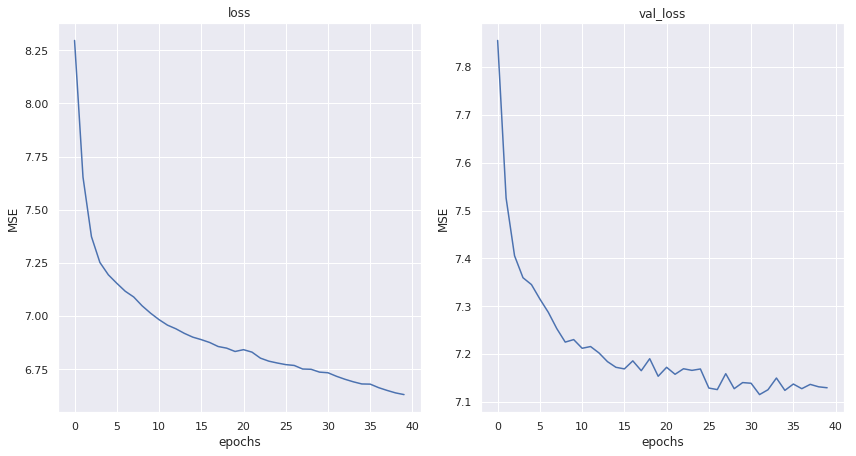

In [120]:
createSubPlots(modelHist.history.values(),titles=list(modelHist.history.keys()))
# saveFig()

In [88]:
def forceDiscontinuity(values,sequenceLength,skip=0):
    def addNans(values,sequenceLength,skip):
        
        values=values.reshape(-1,sequenceLength)
        nans=np.array([np.nan]*(values.shape[0]*(skip+1))).reshape(values.shape[0],-1)
        values = np.concatenate((values,nans),axis=1).reshape(-1)
        return values
    return addNans(np.arange(len(values)),sequenceLength,skip), addNans(values,sequenceLength,skip)

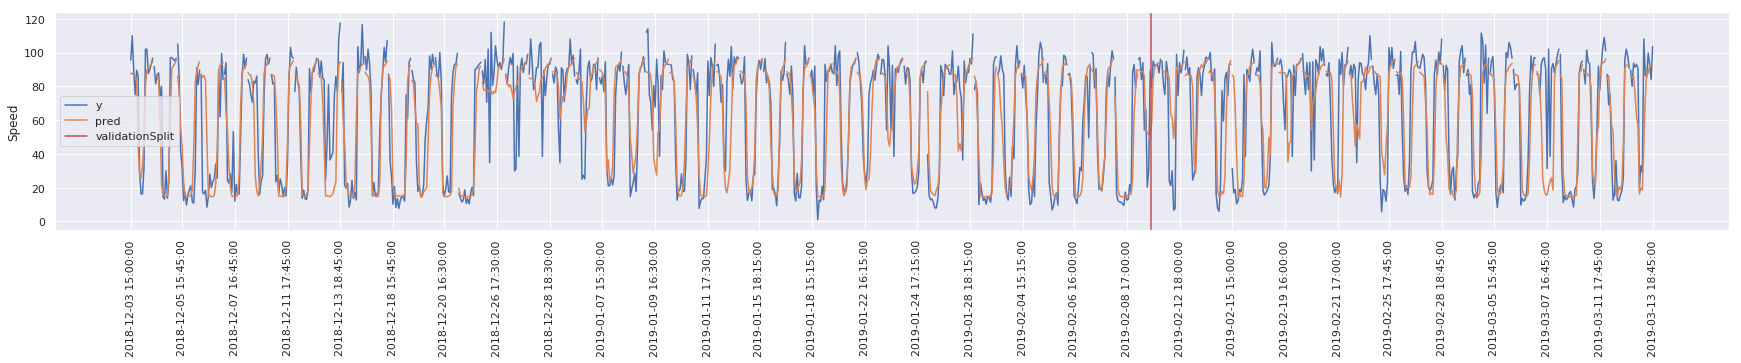

In [121]:
plt.figure(figsize=(30,4))
idx = 77
plt.plot(*data_model.getSplitSequences(yys[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
plt.plot(*data_model.getSplitSequences(preds[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
dates = np.array([data_model.getIndexes(i)[1][0] for i in range(len(yys))])
plt.xticks(ticks = np.arange(len(yys))[np.r_[:len(yys)-1:30j].astype(int)],labels = dates[np.r_[:len(yys)-1:30j].astype(int)],rotation='vertical');
plt.ylabel("Speed")
plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
plt.legend(['y','pred','validationSplit'])
# saveFig()

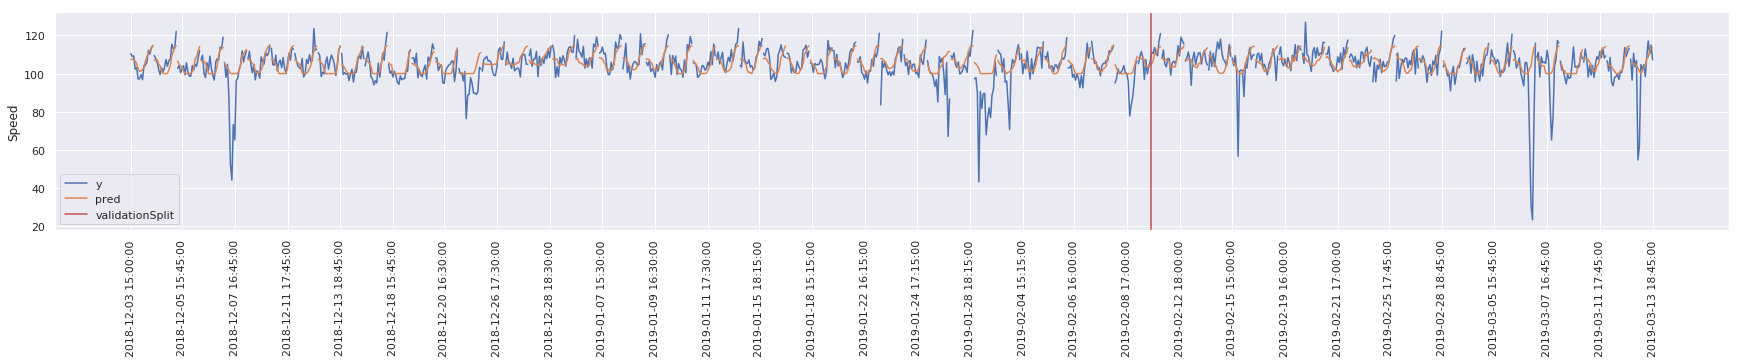

In [111]:
plt.figure(figsize=(30,4))
idx = 208
plt.plot(*data_model.getSplitSequences(yys[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
plt.plot(*data_model.getSplitSequences(preds[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
dates = np.array([data_model.getIndexes(i)[1][0] for i in range(len(yys))])
plt.xticks(ticks = np.arange(len(yys))[np.r_[:len(yys)-1:30j].astype(int)],labels = dates[np.r_[:len(yys)-1:30j].astype(int)],rotation='vertical');
plt.ylabel("Speed")
plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
plt.legend(['y','pred','validationSplit'])
# saveFig()

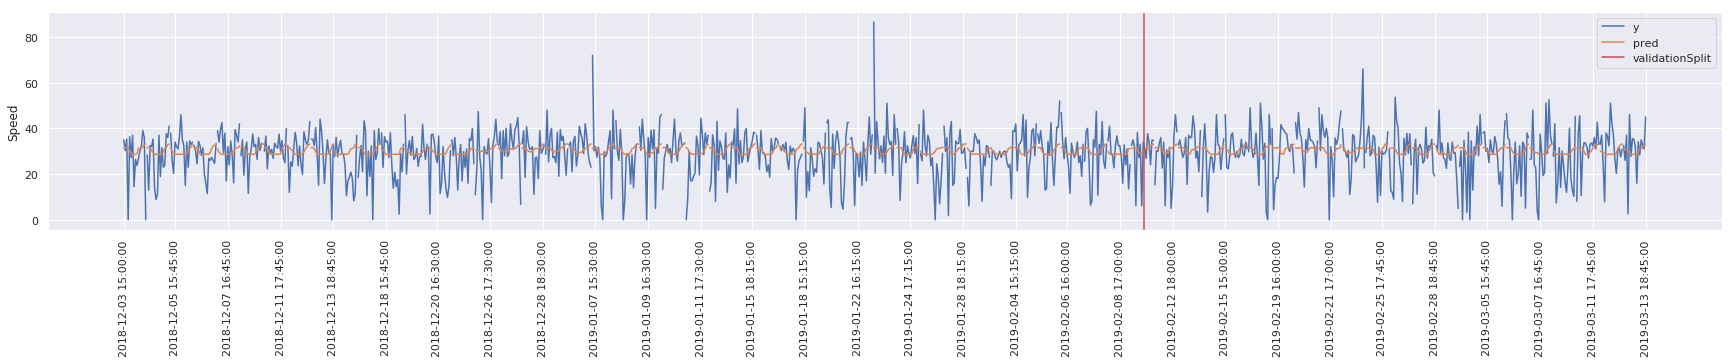

In [112]:
plt.figure(figsize=(30,4))
idx = 300
plt.plot(*data_model.getSplitSequences(yys[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
plt.plot(*data_model.getSplitSequences(preds[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
dates = np.array([data_model.getIndexes(i)[1][0] for i in range(len(yys))])
plt.xticks(ticks = np.arange(len(yys))[np.r_[:len(yys)-1:30j].astype(int)],labels = dates[np.r_[:len(yys)-1:30j].astype(int)],rotation='vertical');
plt.ylabel("Speed")
plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
plt.legend(['y','pred','validationSplit'])
# saveFig()

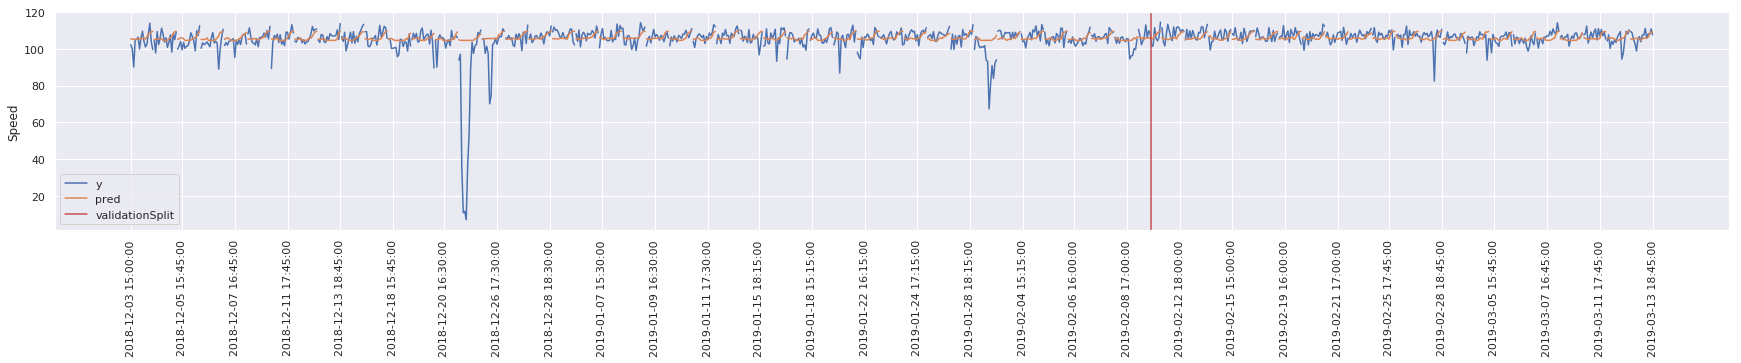

In [113]:
plt.figure(figsize=(30,4))
idx = 628
plt.plot(*data_model.getSplitSequences(yys[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
plt.plot(*data_model.getSplitSequences(preds[:,idx],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
dates = np.array([data_model.getIndexes(i)[1][0] for i in range(len(yys))])
plt.xticks(ticks = np.arange(len(yys))[np.r_[:len(yys)-1:30j].astype(int)],labels = dates[np.r_[:len(yys)-1:30j].astype(int)],rotation='vertical');
plt.ylabel("Speed")
plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
plt.legend(['y','pred','validationSplit'])
# saveFig()

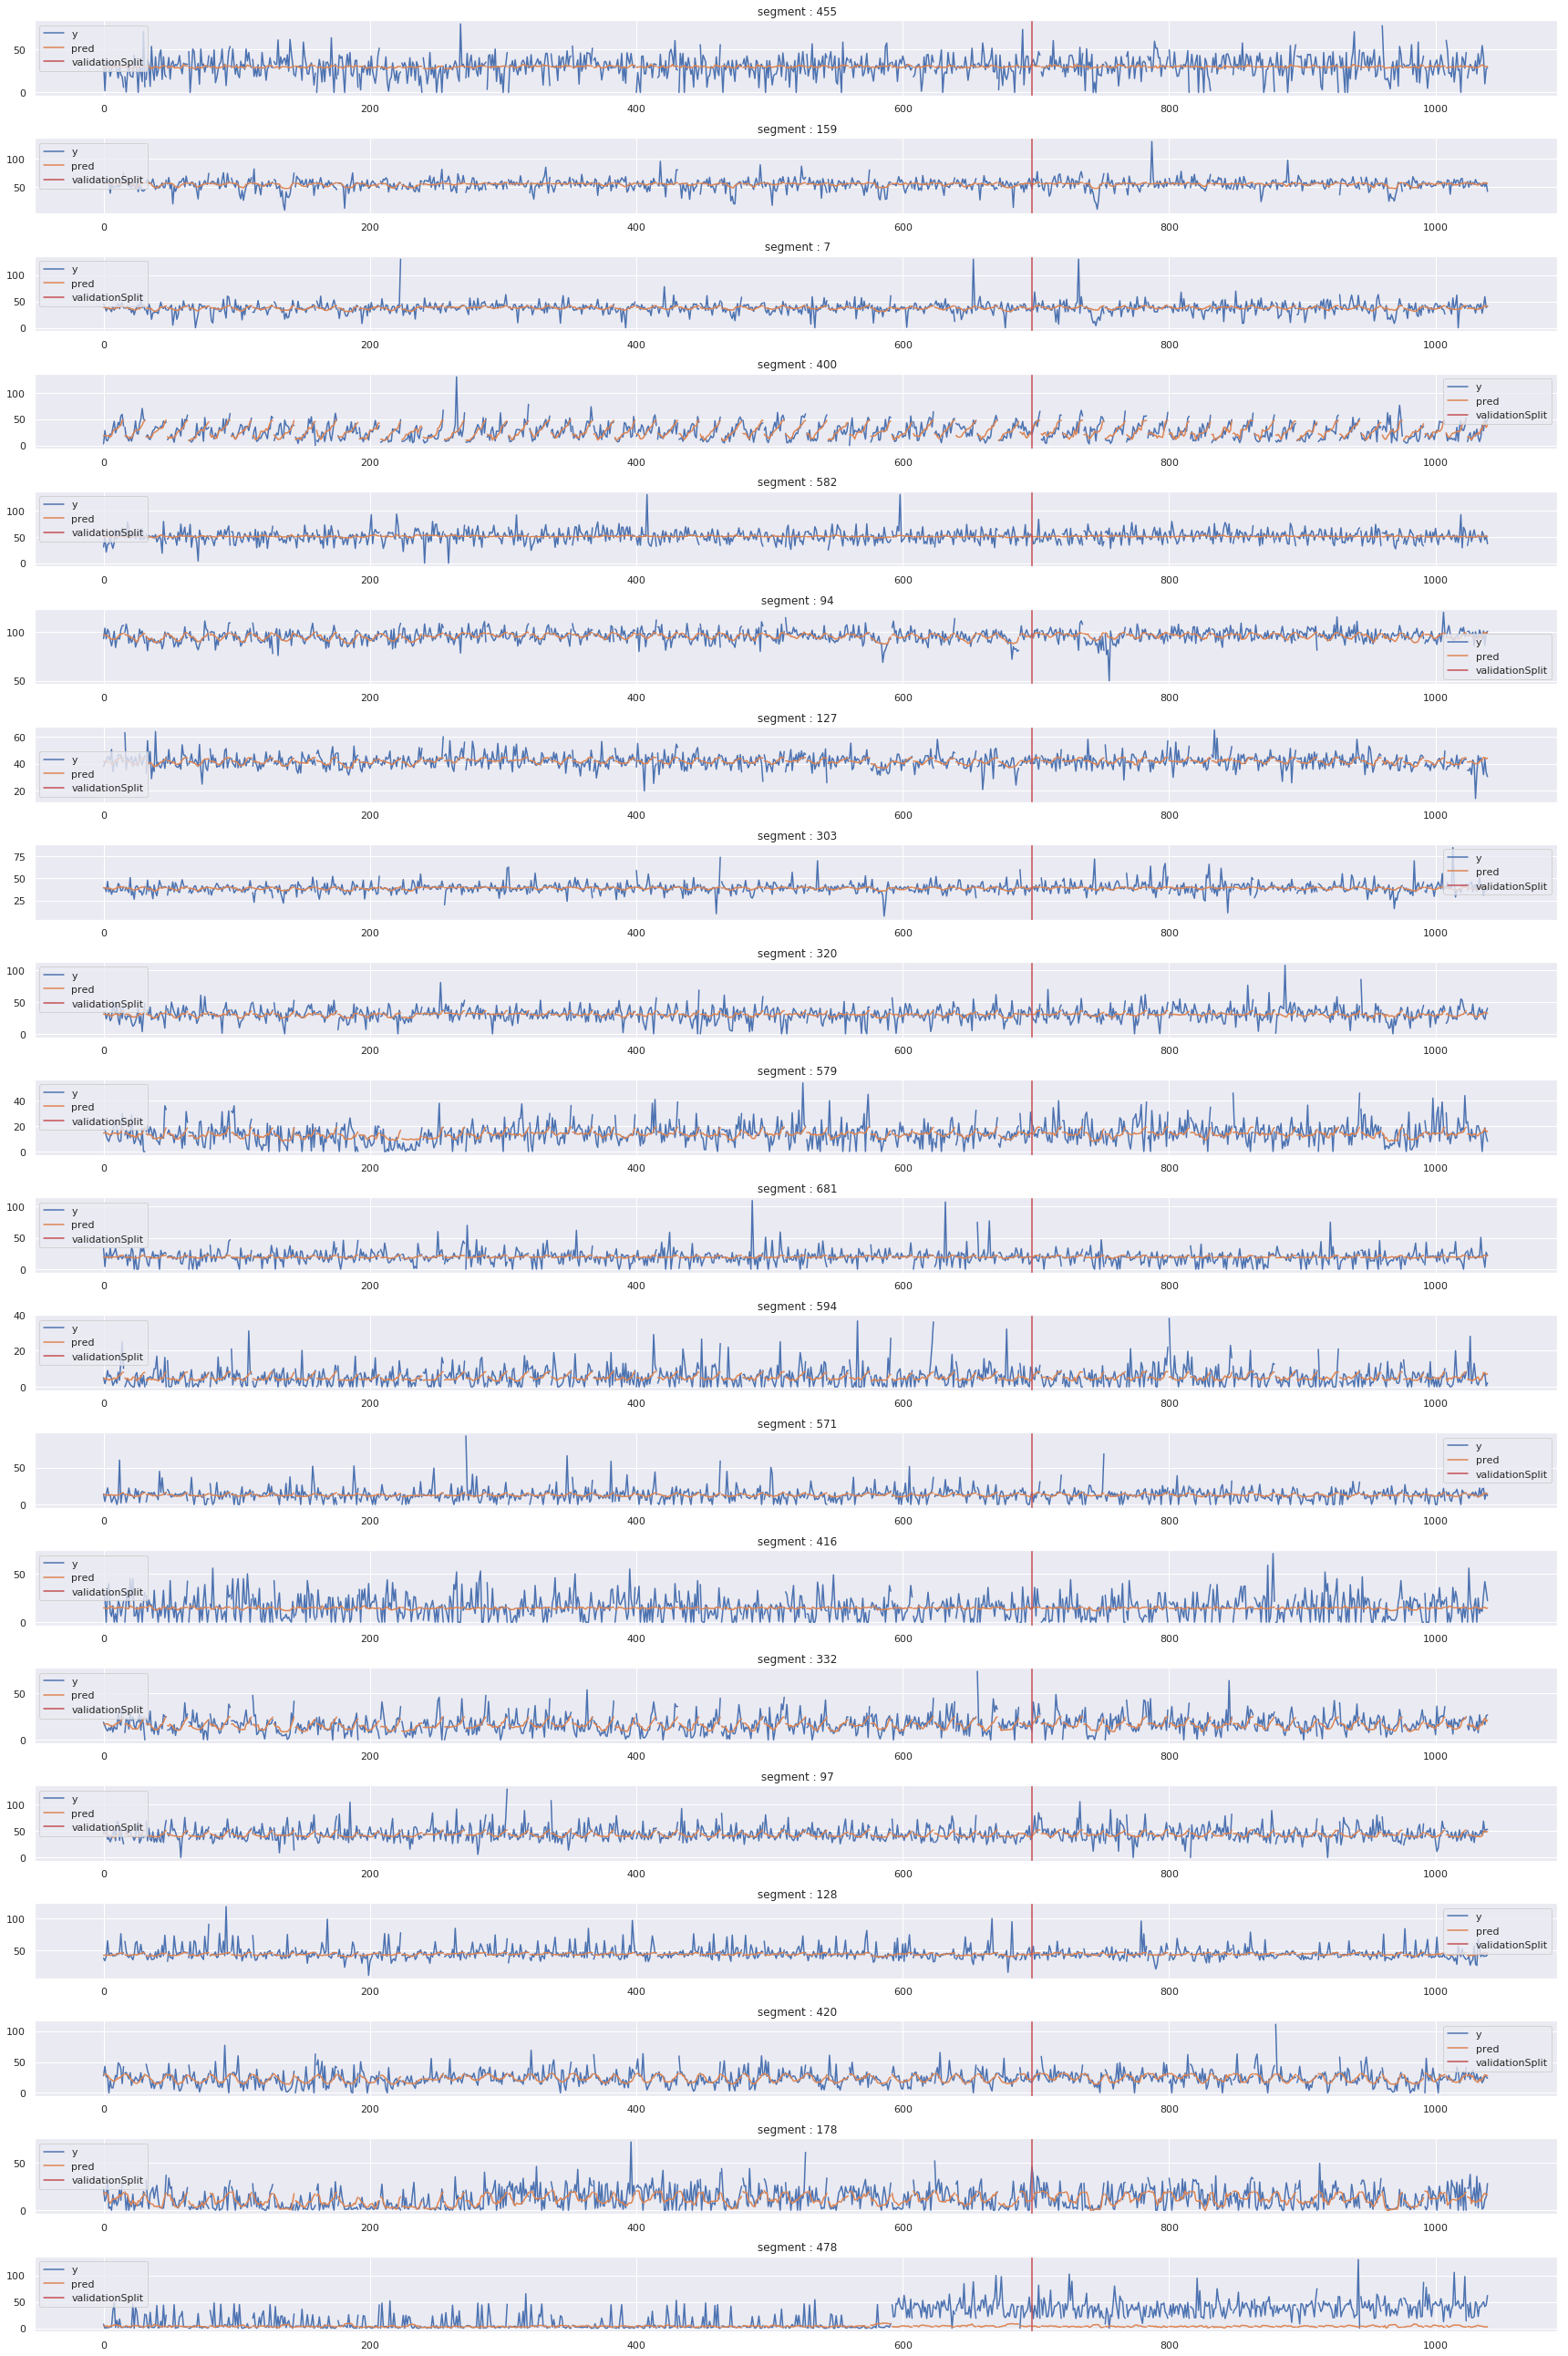

In [122]:
samplePred = np.argsort(data_model.y.mean(axis=0)[0]-data_model.predict('full').mean(axis=0))[np.r_[280:nSegments-1:20j].astype(int)]

plt.figure(figsize=(24,36))
preds = data_model.getRawYData(data_model.predict('full'))
yys = data_model.getRawYData(data_model.y)
for ix, xSample in enumerate(samplePred):
    plt.subplot(len(samplePred),1,ix+1)
    plt.plot(*data_model.getSplitSequences(yys[:,xSample],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))
    plt.plot(*data_model.getSplitSequences(preds[:,xSample],data_model.sequence_length-data_model.input_lag,skip=data_model.input_lag))

    plt.axvline((data_model.valid_split)*data_model.x.shape[0],c='r')
    plt.legend(['y','pred','validationSplit'])
    plt.title(" segment : {}".format(xSample))
plt.tight_layout()
# preds = pd.concat([getPred(x,y,i,idx=30,mul=MUL) for i in range(len(x))],axis=1).T
# plt.figure(figsize=(18,4))
# plt.plot(preds['y'].values)
# plt.plot(preds['pred'].values)
# plt.axvline(0.75*x.shape[0],c='r')
# plt.legend(['y','pred','validationSplit'])
# plt.savefig("imgs/Dense instant overfit with counts and time.png",dpi=1200,bbox_inches='tight')
# saveFig()

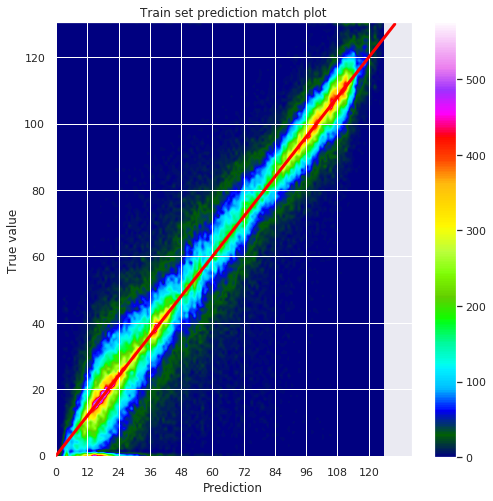

In [115]:
prdsVsYDF=pd.DataFrame([data_model.getRawYData(data_model.predict('train')).flatten(),data_model.getRawYData(y_train).flatten()],index=['pred','y'])

prdsVsYDF=prdsVsYDF.T.astype(int).groupby(['pred','y']).size().unstack().fillna(0).T

prdmin  = -prdsVsYDF.columns.values.min()
plt.figure(figsize=(8,8))
plt.imshow(prdsVsYDF,aspect='auto',origin='bottom-left',cmap =plt.cm.gist_ncar,interpolation='spline16')
plt.xticks(np.arange(len(prdsVsYDF.columns.values))[::12],labels=prdsVsYDF.columns.values[::12])
plt.plot([prdmin,130+prdmin],[0,130],c='red',linewidth=3)
plt.xlabel("Prediction")
plt.ylabel("True value")
plt.title("Train set prediction match plot")
plt.colorbar()
# saveFig()

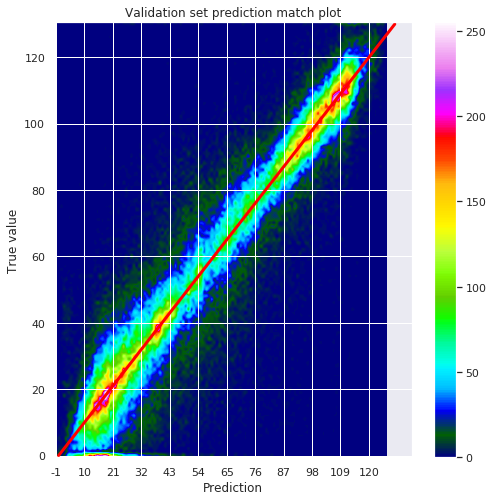

In [123]:
prdsVsYDF=pd.DataFrame([data_model.getRawYData(data_model.predict('test')).flatten(),data_model.getRawYData(y_test).flatten()],index=['pred','y'])

prdsVsYDF=prdsVsYDF.T.astype(int).groupby(['pred','y']).size().unstack().fillna(0).T
prdmin  = -prdsVsYDF.columns.values.min()

plt.figure(figsize=(8,8))
plt.imshow(prdsVsYDF,aspect='auto',origin='bottom-left',cmap =plt.cm.gist_ncar,interpolation='spline16')
plt.xticks(np.arange(len(prdsVsYDF.columns.values))[::11],labels=prdsVsYDF.columns.values[::11])
plt.plot([prdmin,130+prdmin],[0,130],c='red',linewidth=3)
plt.xlabel("Prediction")
plt.ylabel("True value")
plt.title("Validation set prediction match plot")
plt.colorbar()
# saveFig()

Text(0.5, 1.0, 'pred vs true')

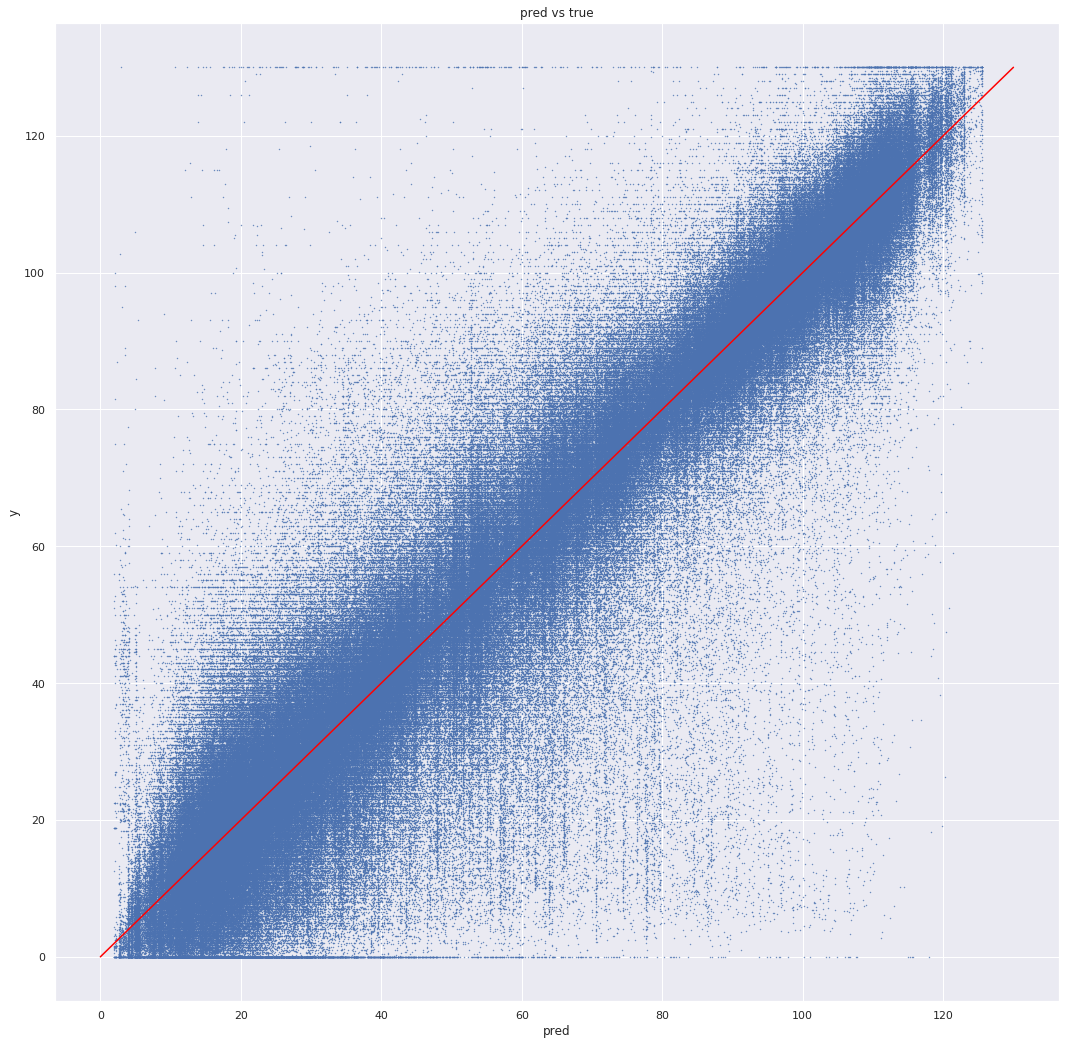

In [92]:
plt.figure(figsize=(18,18))
plt.plot(data_model.getRawYData(data_model.predict('full')).flatten(),data_model.getRawYData(data_model.y).flatten(), linestyle='', marker='o', markersize=0.4)
plt.ylabel("y")
plt.xlabel("pred")
plt.plot([0,130],[0,130],c='red')
plt.title("pred vs true")
# saveFig()

In [128]:
def plotPredictions(segments,data_model, yDF,predDF, timesteps,mergedIndex,updatedcounts,folium_map=None):
    if folium_map == None :
        folium_map = Plotting.getFoliumMap()
    layers=[]
    colors = ((np.abs(yDF.clip(lower=15) - predDF.clip(lower=15))+1)/(yDF.clip(lower=15)+1)).clip(upper=1)
    laggedX = data_model.restoreXAsDF(data_model.x)
    predSegs = segments[segments.segmentID.isin(mergedIndex[mergedIndex.isin(yDF.index)].index)]
    segment_overall_mean = [data_model.data.mean(axis=1).loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
    segment_timestamp_mean = data_model.data.groupby(pd.DatetimeIndex(data_model.data.columns).time,axis=1).mean()
    for t in timesteps :  
        colorList=[colors[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        y= [yDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        preds = [predDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        segCounts=[updatedcounts[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        timestampLaggedX= [laggedX[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        current_segment_timestamp_mean = [segment_timestamp_mean[t.time()].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        popups = ["segment : {:},<br> y : {:.2f},<br> pred : {:.2f},<br> %error : {:.0f}%,<br> count : {:}<br>mean: {:}<br>timestamp_mean: {:}<br>x: {:} "\
                  .format(seg,yi,predi,props*100,count,mean,timestamp_mean,np.array(x).astype(int)) 
                  for seg,yi,predi,props,count,mean,timestamp_mean,x 
                  in zip(predSegs.segmentID,y,preds,colorList,segCounts,segment_overall_mean,current_segment_timestamp_mean,timestampLaggedX)]
        pos = yDF.columns.get_loc(t)
        layer = getPredictionLayer(predSegs,colorList,folium_map,str(t),popups)
        layers.append(layer)
        
    return Plotting.stackHistotyLayers([*layers,folium.TileLayer()],folium_map)

def getPredictionLayer(segments,colors,folium_map,name='layer',popups=[]):
    layer = folium.plugins.FeatureGroupSubGroup(folium_map,name=name,show=False, overlay=False)
    [folium.PolyLine(locations=[lo[::-1] for lo in x['coordinates']], color=matplotlib.colors.rgb2hex(plt.cm.brg_r(color/2)),popup=pop).add_to(layer) for x,color,pop in zip(segments['loc'],colors,popups)]
    return layer

yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))


# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)


folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")
folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = plotPredictions(segmentsMeta,data_model,yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],mergedIndex,updatedcounts,folium_map=folium_map.m1)
folium_validation_map = plotPredictions(segmentsMeta,data_model,yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],mergedIndex,updatedcounts,folium_map=folium_map.m2)



In [208]:
folium_map.save('PRED map.html')

In [ ]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))
colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)

In [ ]:
def plotPredHeatMap(yDF,predDF,cost=None):
    if cost :
        colors= cost(yDF,predDF)
    else :
        colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)
    
    plt.figure(figsize=(18,12))
    plt.imshow(colors,aspect='auto')
    plt.colorbar()
    
plotPredHeatMap(yDF,predDF)

In [ ]:
def plotPredHeatMap(yDF,predDF,cost=None):
    if cost :
        colors= cost(yDF,predDF)
    else :
        colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)
    
    plt.figure(figsize=(18,12))
    plt.imshow(colors,aspect='auto')
    plt.colorbar()
    
plotPredHeatMap(yDF,predDF)
plt.savefig("imgs/Dense instant overfit with counts and time heatmap.png",dpi=1200,bbox_inches='tight')